In [159]:
#importing dependencies and Data
!pip3 install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [160]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu , True)

In [161]:
# for gpu in gpus:
#   print(gpu)


In [162]:
import tensorflow_datasets as tfds
from matplotlib  import  pyplot as plt


In [163]:
#downloading and importing out datasets using tensorflow dataset api to being in the data source

ds = tfds.load('fashion_mnist', split = 'train')

In [164]:
ds.as_numpy_iterator().next()['label']

2

In [165]:
#visualising datasets and building a pipeline
import numpy as np
import pandas as pd


In [166]:
dataIterator = ds.as_numpy_iterator()#setting up an iterator  to call a  new batch of images from dataset out of the pipeline each time its  called


In [167]:
dataIterator.next()['image'].shape

(28, 28, 1)

In [168]:
np.squeeze(dataIterator.next()['image']).shape


(28, 28)

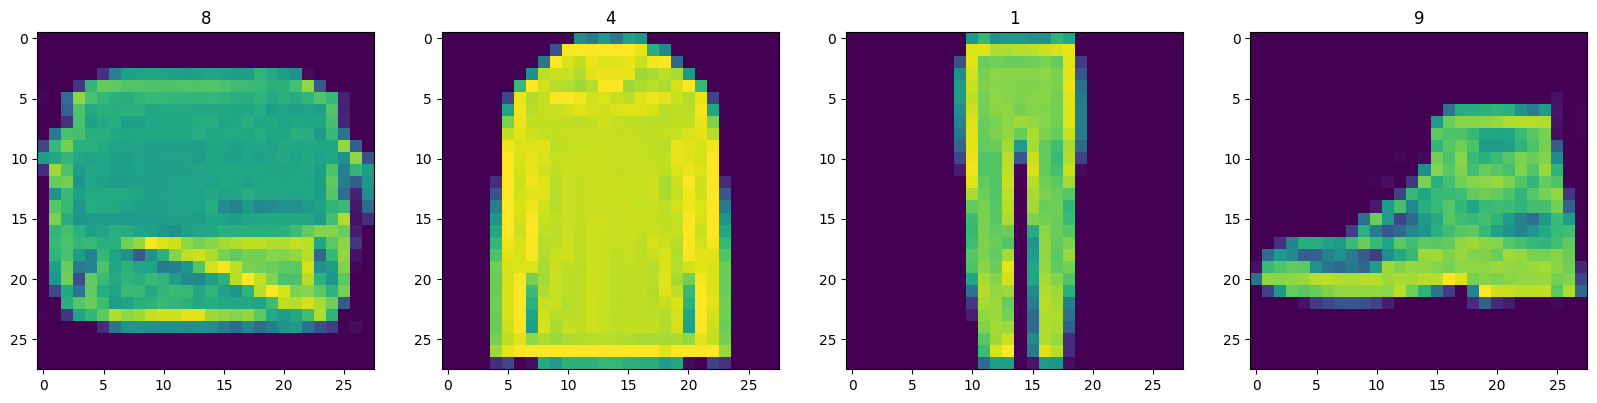

In [169]:
#creating subplots
fig  , ax = plt.subplots(ncols = 4 ,  figsize = (20,20))#setting up subplot format
#loop 4 times and get images usiing dataIterator
for idx in range(4):
  sample = dataIterator.next()
  ax[idx].imshow(np.squeeze(sample['image'])) #ax: subplot
  ax[idx].title.set_text(sample['label'])

In [170]:
#data processing(scaling)
def scale_images(data):
  image = data['image']#extracting image only
  return image/255

In [171]:
#STEPS WE  DO TO  BUILD A DATA PIPELNE FOR TENSORFLOW
# '''MCSBP:
# map
# cache
# shuffle
# batch
# prefetch'''

In [172]:
ds = tfds.load('fashion_mnist', split = 'train')
#running the dataset through thr scale_images preprocessinf step
ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
#batch into 128 images per sample
ds = ds.batch(128)
#reduces the likelihoof of bottlenecking
ds = ds.prefetch(64)


BUILDING THE NEURAL NETWORK

In [173]:
#importing components
from tensorflow.keras.models import Sequential
from  tensorflow.keras.layers import Conv2D , Dense , Flatten , Reshape , LeakyReLU , Dropout , UpSampling2D

In [174]:
def build_generator():
  model = Sequential()
  #takes in random values and reshapes it to 7x7x128
  #beginning of generated image
  model.add(Dense(7*7*128 , input_dim = 128))
  model.add(LeakyReLU(0.2))#activation fxn
  model.add(Reshape((7,7,128)))

  #upsampling box
  model.add(UpSampling2D())
  model.add(Conv2D(128 , 5 , padding = 'same'))
  model.add(LeakyReLU(0.2))

  #upsampling blocke 2
  model.add(UpSampling2D())
  model.add(Conv2D(128 , 5 , padding = 'same'))
  model.add(LeakyReLU(0.2))

  #convolutional block
  model.add(Conv2D(128, 4, padding = 'same'))
  model.add(LeakyReLU(0.2))

#convolutional block 2
  model.add(Conv2D(128, 4, padding = 'same'))
  model.add(LeakyReLU(0.2))

  #final layere
  model.add(Conv2D(1,4,padding = 'same', activation = 'sigmoid'))

  return model

In [175]:
generator = build_generator()
generator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_10 (UpSampli  (None, 14, 14, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [176]:
img = generator.predict(np.random.randn(4,128,1)) # 4 no. of images and 128 number of random values
img.shape

1/1 [==============================] - 0s 206ms/step


(4, 28, 28, 1)

In [177]:
#creating subplots
# fig  , ax = plt.subplots(ncols = 4 ,  figsize = (20,20))#setting up subplot format
# #loop 4 times and get images usiing dataIterator
# for idx , img in enumerate(img):
#   img = np.squeeze(img)
#   #img = img.reshape((28, 28))
#   print(img.shape)

#   ax[idx].imshow(img) #ax: subplot
#   ax[idx].title.set_text(idx)

In [178]:
#building discriminator
def build_discriminator():
  model = Sequential()
# first conv block
  model.add(Conv2D(32,5,input_shape= (28,28,1))) #input shape = output shape of the generator
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #second block
  model.add(Conv2D(64,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(128,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(256,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #flatten then pass through dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1 , activation = 'sigmoid'))


  return model

In [179]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_20 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_47 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_47 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_21 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_48 (Conv2D)          (None, 16, 16, 128)     

In [180]:

img.shape

(4, 28, 28, 1)

In [181]:
discriminator.predict(img)

1/1 [==============================] - 0s 144ms/step


array([[0.50625974],
       [0.5064068 ],
       [0.50639826],
       [0.5064402 ]], dtype=float32)

It is important to ensure that generator ans discriminator are trained paralley therefore .fit won't help, we'll need a different approach

In [182]:
#CONSTRUCTON TRAINING LOOP
#setting up losses
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses  import BinaryCrossentropy



In [183]:
g_opt = Adam(learning_rate = 0.0001)
d_opt = Adam(learning_rate= 0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [184]:
#setting up the sub classsed model
# importing the base model class to subclass our training step

from tensorflow.keras.models import Model


In [185]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}


In [186]:
#instance of subclassed model
fashGAN= FashiionGAN(generator , discriminator)

In [187]:
#compiling model
fashGAN.compile(g_opt , d_opt , g_loss , d_loss)

In [188]:
#BUILD CALLBACK
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback


In [189]:
from google import colab
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [190]:
class ModelMonitor(Callback):
  def __init__(self , num_img = 3 , latent_dim = 128):
    self.num_img = num_img
    self.latent_data = latent_dim
  def on_epoch_end(self, epoch , logs = None):
    random_latent_vectors  = tf.random.uniform((self.num_img , self.latent_dim,1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images.numpy()
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join('images' , f'generated_img_{epoch}_{i}.png'))





In [191]:
#TRAINING
hist = fashGAN.fit(ds, epochs = 20 , callbacks = [ModelMonitor()])

Epoch 1/20


NameError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "<ipython-input-92-b60c43120c92>", line 19, in train_step
        real_images = df # Assuming 'image' is the key for real images

    NameError: name 'df' is not defined


In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [ ]:
generator.load_weights(os.path.join('archive', 'generatormodel.h5'))

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [ ]:
#Save the Model
generator.save('generator.h5')
discriminator.save('discriminator.h5')